In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('./'))
from mds.mds import mds
from mds.visualizationtools import plot_interpolation_2d, plot_interpolation_3d, compress_to_sphere

**IDEA:**
<br>$(S^3,S^2,\pi,S^1)$ is a fiber bundle, where $\pi : S^3 \to S^2$ being the Hopf
fibration, and for every $p\in S^2, \pi^{-1}(p)=S^1$. The idea is to visualize the fibers corresponding to some points in $S^2$.

- Step 1:
<br>Sample $n$ points in $S^2$ in local coordinates.

In [2]:
def localcoordsampling_2sphere(n):
    """
    Generate approximately equidistant points on the 2-sphere and return them in
    spherical coordinates (local parametrization).

    Parameters:
    n (int): Number of points to sample.

    Returns:
    np.ndarray: Array of shape (n, 2), where each row is (theta, phi).
    """
    phi = (1 + np.sqrt(5)) / 2

    points = np.zeros((n, 2))

    for k in range(n):
        theta = np.arccos(1 - 2 * (k + 0.5) / n)  # Latitude (theta), range [0, π]
        phi_k = 2 * np.pi * (k / phi**2)          # Longitude (phi), range [0, 2π]

        points[k, 0] = theta
        points[k, 1] = phi_k

    return points

- Step 2:
<br>Compute the corresponding fiber of each point, through the inverse of the Hopf fibration.
$$
p=(\theta,\phi)\in S^2,\quad H^{-1}((\theta,\phi))=\{\left(\cos(\frac{\theta}{2}) e^{i\psi}, \sin(\frac{\theta}{2} e^{i(\phi + \psi)})\right), \psi\in[0,2\pi) \}
$$
We can already return $n_{points}$ of the fiber for each point, always the same amount for each fiber,
and in the end have something of this form:
$$
F = \begin{pmatrix}
f_{11} & ... & f_{1n} \\
\vdots & & \vdots\\
f_{d1} & ... & f_{dn}
\end{pmatrix},
$$
where $n$ is the number of points sampled in each fiber and $d$ is the number of
points sampled in $S^2$.

In [3]:
def hopf_fibration_inverse(points, num_samples):
    """
    Computes the inverse Hopf fibration for multiple points on S^2.
    
    Parameters:
        points (ndarray): Array of shape (N, 2) containing spherical coordinates (theta, phi) of points on S^2.
                          theta: Polar angle (0 <= theta <= pi)
                          phi: Azimuthal angle (0 <= phi < 2pi)
        num_samples (int): Number of points to sample from each fiber.
    
    Returns:
        list of tuples: Each tuple contains:
            - fiber_index (int): The index of the point on S^2 the fiber belongs to.
            - sampled_fiber (ndarray): Array of shape (num_samples, 4) containing the sampled fiber points in S^3.
    """
    fibers = []
    
    for index, (theta, phi) in enumerate(points):
        
        psi_values = np.linspace(0, 2 * np.pi, num_samples, endpoint=False)
        
        half_theta = theta / 2
        z1 = np.cos(half_theta) * np.exp(1j * psi_values)  
        z2 = np.sin(half_theta) * np.exp(1j * (phi + psi_values))  
        
        x1, y1 = np.real(z1), np.imag(z1)
        x2, y2 = np.real(z2), np.imag(z2)
        
        # Stack into a (num_samples, 4) array
        sampled_fiber = np.column_stack([x1, y1, x2, y2])

        fibers.append((index, sampled_fiber))
    
    return fibers

- Step 3: Already automatized in mds function:
<br> Compute distance matrix (symmetric matrix of size $d\cdot n\times d\cdot n$)

$$
D = \begin{pmatrix}
d(f_{11},f_{11}) & ... & d(f_{11},f{1n}) & ... & d(f_{11}, f_{d1}) & ... & d(f_{11},f_{dn}) \\
\vdots & & & & & & \vdots\\
d(f_{dn},f_{11}) & ... & d(f_{dn},f{1n}) & ... & d(f_{dn}, f_{d1}) & ... & d(f_{dn},f_{dn}) 
\end{pmatrix}
$$
<br>Convert distance matrix to B matrix needed as input for mds. Project fibers into
R^3 using mds.

- Step 4: Visualization
<br>Plot points from each fiber the same colour and interpolate.

**EXAMPLES:**

In [10]:
points_3 = localcoordsampling_2sphere(3)
num_samples = 1000
fiber_index, sampled_fibers = zip(*hopf_fibration_inverse(points_3, num_samples))
sampled_fibers = np.vstack(sampled_fibers)  # Shape (30, 4)
fiber_index = np.repeat(fiber_index, num_samples)  # Shape (30,)



In [11]:
x, y, z = mds(sampled_fibers, 3)

There are 3000 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 2953 (98.43%)


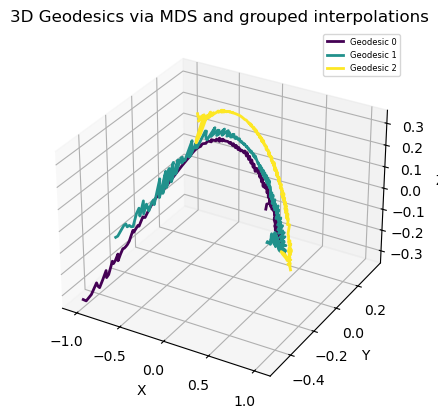

In [12]:
plot_interpolation_3d(x,y,z,fiber_index)

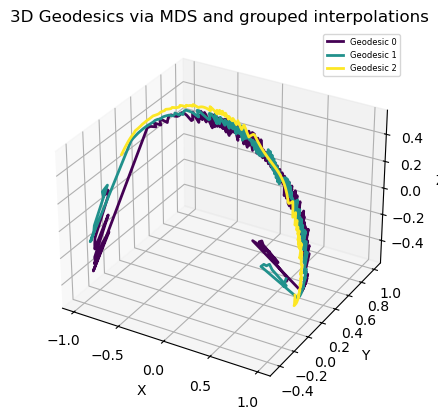

In [13]:
xc, yc, zc = compress_to_sphere(3,x,y,z)
plot_interpolation_3d(xc,yc,zc,fiber_index)

In [8]:
x,y = mds(sampled_fibers,2)

There are 1500 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 1464 (97.60%)


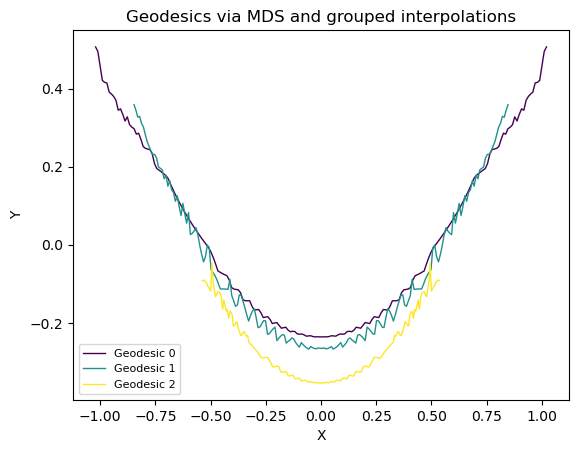

In [9]:
plot_interpolation_2d(x,y,fiber_index)